In [1]:
import os
import sys
import json
import torch
import random
import configs
import numpy as np
import transformers
import pandas as pd
import torch.nn as nn
from PIL import Image
import tensorflow as tf
import torch.nn.functional as F
import matplotlib.pyplot as plt
from torch.utils.tensorboard import SummaryWriter
from tqdm.auto import tqdm

2023-12-10 11:09:07.825616: E tensorflow/compiler/xla/stream_executor/cuda/cuda_dnn.cc:9342] Unable to register cuDNN factory: Attempting to register factory for plugin cuDNN when one has already been registered
2023-12-10 11:09:07.825694: E tensorflow/compiler/xla/stream_executor/cuda/cuda_fft.cc:609] Unable to register cuFFT factory: Attempting to register factory for plugin cuFFT when one has already been registered
2023-12-10 11:09:07.825725: E tensorflow/compiler/xla/stream_executor/cuda/cuda_blas.cc:1518] Unable to register cuBLAS factory: Attempting to register factory for plugin cuBLAS when one has already been registered
2023-12-10 11:09:07.833633: I tensorflow/core/platform/cpu_feature_guard.cc:182] This TensorFlow binary is optimized to use available CPU instructions in performance-critical operations.
To enable the following instructions: AVX2 FMA, in other operations, rebuild TensorFlow with the appropriate compiler flags.
2023-12-10 11:09:08.826478: W tensorflow/compiler/

In [2]:
configs.set_seed(42)

In [3]:
!nvidia-smi

Sun Dec 10 11:09:09 2023       
+---------------------------------------------------------------------------------------+
| NVIDIA-SMI 545.23.06              Driver Version: 545.23.06    CUDA Version: 12.3     |
|-----------------------------------------+----------------------+----------------------+
| GPU  Name                 Persistence-M | Bus-Id        Disp.A | Volatile Uncorr. ECC |
| Fan  Temp   Perf          Pwr:Usage/Cap |         Memory-Usage | GPU-Util  Compute M. |
|                                         |                      |               MIG M. |
|=========================================+======================+======================|
|   0  NVIDIA GeForce RTX 2080 Ti     On  | 00000000:01:00.0 Off |                  N/A |
| 27%   28C    P8              21W / 250W |      3MiB / 11264MiB |      0%      Default |
|                                         |                      |                  N/A |
+-----------------------------------------+----------------------+--

In [4]:
device = configs.set_device(2)

There are 8 GPU(s) available.
We will use the GPU: NVIDIA A100-SXM4-80GB


In [5]:
from tensorflow.keras.datasets import cifar10

(train_images, train_labels), (test_images, test_labels) = cifar10.load_data()


image_paths = []
labels = []

save_dir = 'cifar10_images'
if not os.path.exists(save_dir):
    os.makedirs(save_dir)

for i in range(len(train_images)):
    image_path = os.path.join(save_dir, f"train_image_{i}.jpg")
    tf.keras.preprocessing.image.save_img(image_path, train_images[i])
    image_paths.append(image_path)
    labels.append(train_labels[i][0])


for i in range(len(test_images)):
    image_path = os.path.join(save_dir, f"test_image_{i}.jpg")
    tf.keras.preprocessing.image.save_img(image_path, test_images[i])
    image_paths.append(image_path)
    labels.append(test_labels[i][0])

print(len(train_images), "\n")
print(len(test_images), "\n")
print(len(image_paths))

50000 

10000 

60000


In [6]:
classes = {0: "airplane", 1: "automobile", 2: "bird", 3: "cat", 4: "deer", 5: "dog", 6: "frog", 7: "horse", 8: "ship", 9: "truck"}

titles = []
for im in tqdm(range(len(image_paths))):
    titles.append(classes[labels[im]])

  0%|          | 0/60000 [00:00<?, ?it/s]

In [7]:
def remove_prefixes(strings):
    prefixes = ['a', 'an', 'the']
    result = []

    for string in strings:
        words = string.split()
        if words[0].lower() in prefixes:
            result.append(' '.join(words[1:]))
        else:
            result.append(string)

    return result

with open("conceptnet_cifar10_filtered_new.txt", "r") as f:
    concepts = f.read().lower().split("\n")
    concepts = remove_prefixes(concepts)

In [8]:
class CLIPDataset():
    def __init__(self, list_image_path, list_txt):
        self.image_path = list_image_path
        self.title  = list_txt
        self.title_text = [classes[l] for l in list_txt]

    def __len__(self):
        return len(self.title)

    def __getitem__(self, idx):
        image = Image.open(self.image_path[idx])
        title = self.title[idx]
        title_text = self.title_text[idx]
        return image, title, title_text


def collate_fn(batch):
    return {
        'image': [x[0] for x in batch],
        'title': [x[1] for x in batch],
        'title-text': [x[2] for x in batch]
    }

dataset = CLIPDataset(list_image_path=image_paths, list_txt=labels) # but it can be with <<titles>> to get textual annotations for class labels
train_dataset, val_dataset, test_dataset = torch.utils.data.random_split(dataset, [50000, 3000, 7000])

train_loader = torch.utils.data.DataLoader(train_dataset, batch_size=32, shuffle=True, collate_fn=collate_fn, pin_memory=True)
val_loader = torch.utils.data.DataLoader(val_dataset, batch_size=32, shuffle=False, collate_fn=collate_fn, pin_memory=True)
test_loader = torch.utils.data.DataLoader(test_dataset, batch_size=32, shuffle=False, collate_fn=collate_fn, pin_memory=True)

assert len(dataset) == len(image_paths)
print("Dataset size: {}".format(len(dataset)), "\n")

train_dataset, val_dataset, test_dataset = torch.utils.data.random_split(dataset, [50000, 3000, 7000])
print("Train set: {}".format(len(train_dataset)), "\n")
print("Validation set: {}".format(len(val_dataset)), "\n")
print("Test set: {}".format(len(test_dataset)))

Dataset size: 60000 

Train set: 50000 

Validation set: 3000 

Test set: 7000


In [9]:
from transformers import CLIPModel, CLIPProcessor, AutoTokenizer

def preprocess_loader(loader, concepts: list):
    preprocessed_batches = []
    processor = CLIPProcessor.from_pretrained("openai/clip-vit-base-patch32")
    for batch in tqdm(loader):
        preprocessed_batch = preprocess_batch(batch, processor, concepts)
        preprocessed_batches.append(preprocessed_batch)
    return preprocessed_batches

def preprocess_batch(batch, processor, concepts: list):
    return processor(text=concepts, images=batch['image'], return_tensors="pt", padding=True), batch['title'], batch['title-text']

train_loader_preprocessed = preprocess_loader(train_loader, concepts)
val_loader_preprocessed = preprocess_loader(val_loader, concepts)
test_loader_preprocessed = preprocess_loader(test_loader, concepts)

  0%|          | 0/1563 [00:00<?, ?it/s]

  0%|          | 0/94 [00:00<?, ?it/s]

  0%|          | 0/219 [00:00<?, ?it/s]

In [10]:
import transformers

class CBL(nn.Module):
    def __init__(self, k: int=5):
        super().__init__()
        self.k = k

    def forward(self, logits_per_image: torch.Tensor) -> torch.Tensor:
        k = self.k
        top_k_logits, top_k_logits_ids = torch.topk(logits_per_image, k=self.k, dim=1)
        return top_k_logits

class TuningCLIPhead(nn.Module):
    def __init__(self, model_name: str="openai/clip-vit-base-patch32", concepts: list=concepts, classes: dict=classes, cbl_dim: int=5):
        super().__init__()
        self.clip = transformers.CLIPModel.from_pretrained(model_name)
        self.processor = transformers.CLIPProcessor.from_pretrained(model_name)
        for param in self.clip.parameters():
            param.requires_grad=False
        self.cbl_dim = cbl_dim
        self.cbl = CBL(k=self.cbl_dim)
        self.head = nn.Linear(self.cbl_dim, len(classes), bias=False)

    def forward(self, **batch):
        logits = self.clip(**batch).logits_per_image
        out = self.cbl(logits)
        return self.head(out)

In [11]:
torch.cuda.empty_cache()

In [12]:
model = TuningCLIPhead(cbl_dim=len(concepts))
optimizer = torch.optim.Adam(model.parameters(), lr=0.001)
criterion = nn.CrossEntropyLoss()

print("Number of trainable parameters is: {}".format(sum(p.numel() for p in model.parameters() if p.requires_grad == True)))

for state in optimizer.state.values():
    for k, v in state.items():
        if isinstance(v, torch.Tensor):
            state[k] = v.to(device)

Number of trainable parameters is: 1200


In [13]:
import datasets

metric = datasets.load_metric("accuracy")

/tmp/ipykernel_2280610/4031246835.py:3: FutureWarning: load_metric is deprecated and will be removed in the next major version of datasets. Use 'evaluate.load' instead, from the new library 🤗 Evaluate: https://huggingface.co/docs/evaluate
  metric = datasets.load_metric("accuracy")


without clip loss

In [14]:
@torch.no_grad()
@torch.cuda.amp.autocast()
def val_loss_accuracy(model, loader):
    model.eval()
    all_preds = []
    all_labels = []
    val_losses = []
    for batch in tqdm(loader):
        inputs, labels, titles = batch
        inputs = inputs.to(device)
        logits = model(**inputs).squeeze(0)
        targets = torch.tensor(labels, dtype=torch.long)
        loss = criterion(logits, targets.to(device))
        val_losses.append(loss.item())
        preds = torch.argmax(logits, dim=-1)
        all_preds.extend(preds.cpu().numpy())
        all_labels.extend(labels)

    val_accuracy = metric.compute(predictions=all_preds, references=all_labels)
    avg_val_loss = sum(val_losses) / len(val_losses)
    
    return val_accuracy, avg_val_loss

@torch.no_grad()
@torch.cuda.amp.autocast()
def get_test_accuracy(model, loader):
    model.eval()
    all_preds = []
    all_labels = []
    for batch in tqdm(loader):
        inputs, labels, titles = batch
        inputs = inputs.to(device)
        logits = model(**inputs).squeeze(0)
        targets = torch.tensor(labels, dtype=torch.long)
        preds = torch.argmax(logits, dim=-1)
        all_preds.extend(preds.cpu().numpy())
        all_labels.extend(labels)
        
    test_accuracy = metric.compute(predictions=all_preds, references=all_labels)
    
    return test_accuracy

In [ ]:
import wandb

wandb.login()

In [ ]:
model.to(device)
run = wandb.init(project='cifar10-head', entity='semenov-andrei-v')

num_epochs = 40
for epoch in range(num_epochs):
    model.train()
    for batch in tqdm(train_loader_preprocessed, desc=f"Epoch {epoch + 1}/ {num_epochs}"):
        optimizer.zero_grad()
        
        inputs, labels, titles = batch
        inputs = inputs.to(device)
        targets = torch.tensor(labels, dtype=torch.long)
        logits = model(**inputs).squeeze(0)
        
        loss = criterion(logits, targets.to(device))
        loss.backward()
        optimizer.step()
    
    model.eval()
    val_accuracy, avg_val_loss = val_loss_accuracy(model, val_loader_preprocessed)

    wandb.log({"Loss/Train": loss.item(), 
               "Loss/Validation": avg_val_loss, 
               "Accuracy/Validation": val_accuracy['accuracy']}
             )

    print(f"Epoch {epoch + 1}/{num_epochs}, Loss: {loss.item()}, Validation Accuracy: {val_accuracy}")

model.eval()
test_accuracy = get_test_accuracy(model, train_loader_preprocessed)
wandb.log({"Accuracy/Test": test_accuracy['accuracy']})

run.finish()

custom

In [15]:
from typing import Union

class TrainerLogger:
    def __init__(self, logging_dir: Union[str, None]=None):
        self.logging_dir = logging_dir
        if logging_dir != None:
            os.makedirs(self.logging_dir, exist_ok=True)
        self.history = {"epoch": [], "Loss/Train": [], "Loss/Validation": [], "Accuracy/Validation": [], "Accuracy/Test": []}

    def log(self, values):
        for key, value in values.items():
            if key in self.history:
                self.history[key].append(value)
            else:
                self.history[key] = [value]
                
        self.save_to_json("history")

    def save_to_json(self, filename):
        if self.logging_dir is not None:
            filepath = os.path.join(self.logging_dir, f"{filename}.json")
            with open(filepath, 'w') as json_file:
                json.dump(self.history, json_file)

    def plot_summary(self, key):
        if key not in self.history:
            print(f"Key '{key}' not found in history.")
            return

        if key == "Accuracy/Test":
            df = pd.DataFrame({key: [key], 'Percentage': self.history[key]})
            ax = df.plot.barh(x=key, y='Percentage')
            ax.set_xlim(0, 1)
            ax.set_xlabel("Percentage")
            ax.set_title("Accuracy/Test", fontsize=20)
            plt.show()
        else:
            fig, ax = plt.subplots(figsize=(10, 4), dpi=300)
            plt.plot(self.history["epoch"], self.history[key], label=key)
            ax.set_title(f"{key}", fontsize=20)
            ax.set_xlabel("Epochs", fontsize=20)
            if key not in ["epoch", "Accuracy/Validation"]:
                ax.set_ylabel("loss", fontsize=20)
            else:
                ax.set_ylabel(key, fontsize=20)
            ax.legend()
            ax.set_xlim(left=0)
            ax.xaxis.set_major_locator(plt.MaxNLocator(integer=True))
            ax.grid(False)
            plt.show()

In [17]:
logger = TrainerLogger(logging_dir="./customlogdir-2")

In [ ]:
model.to(device)

num_epochs = 300
for epoch in range(num_epochs):
    model.train()
    for batch in tqdm(train_loader_preprocessed, desc=f"Epoch {epoch + 1}/ {num_epochs}"):
        optimizer.zero_grad()
        
        inputs, labels, titles = batch
        inputs = inputs.to(device)
        targets = torch.tensor(labels, dtype=torch.long)
        logits = model(**inputs).squeeze(0)
        
        loss = criterion(logits, targets.to(device))
        loss.backward()
        optimizer.step()
    
    model.eval()
    val_accuracy, avg_val_loss = val_loss_accuracy(model, val_loader_preprocessed)

    logger.log({
        "epoch": epoch,
        "Loss/Train": loss.item(),
        "Loss/Validation": avg_val_loss,
        "Accuracy/Validation": val_accuracy['accuracy']
    })

    print(f"Epoch {epoch + 1}/{num_epochs}, Loss: {loss.item()}, Validation Accuracy: {val_accuracy}")

model.eval()
test_accuracy = get_test_accuracy(model, train_loader_preprocessed)
logger.log({"Accuracy/Test": test_accuracy['accuracy']})

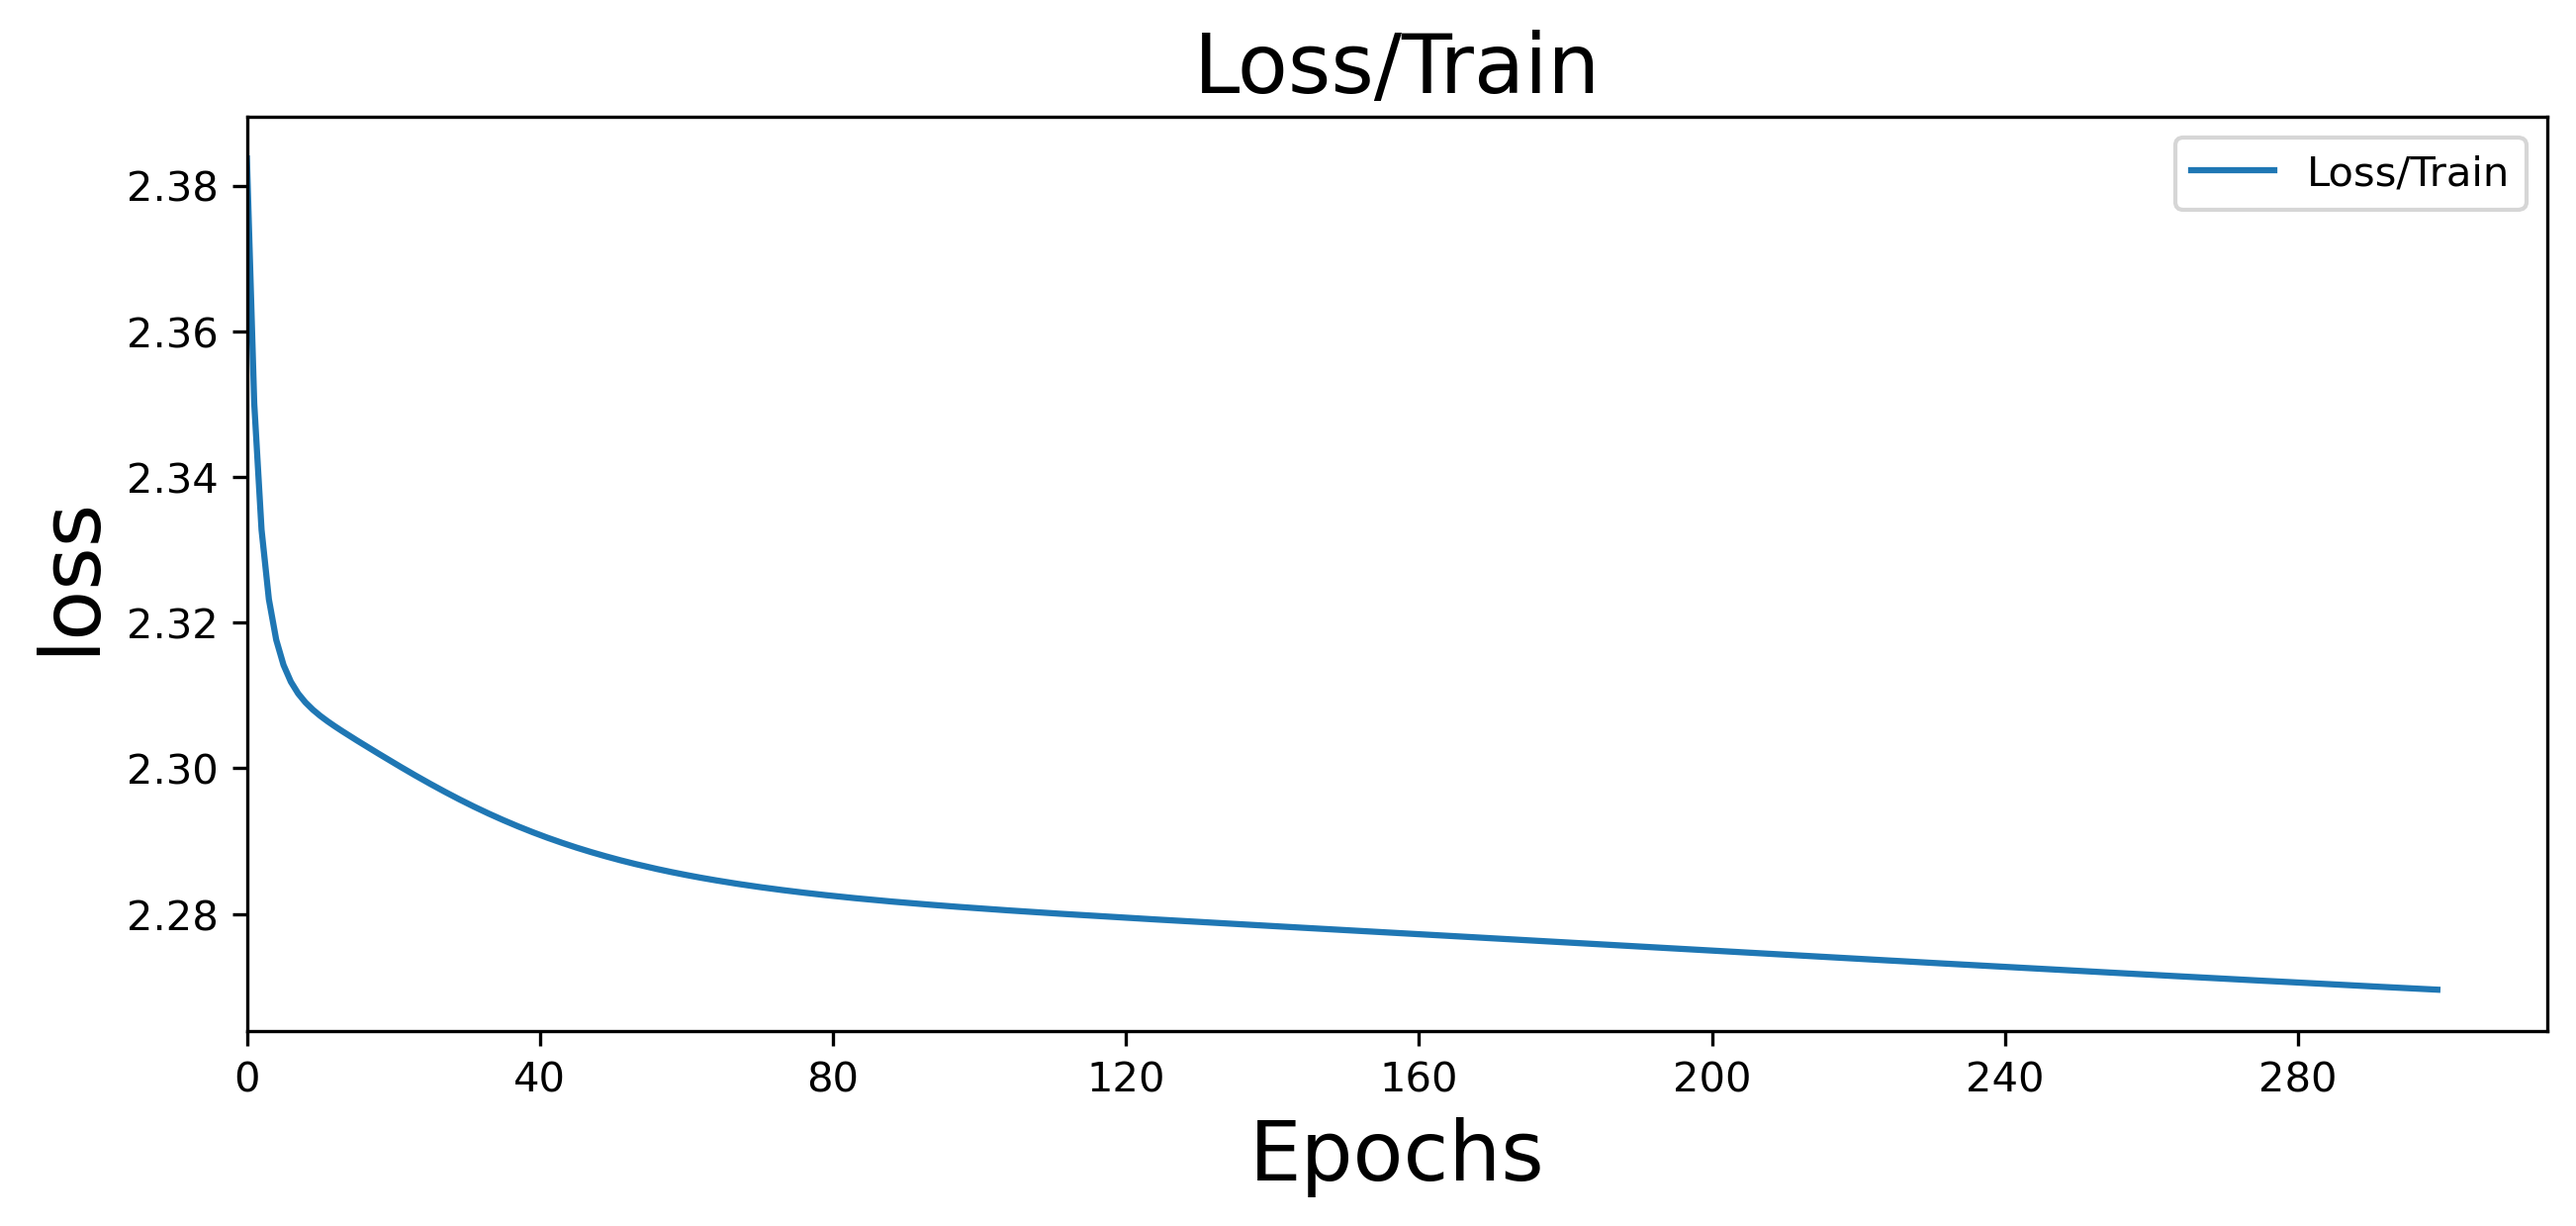

In [19]:
logger.plot_summary("Loss/Train")

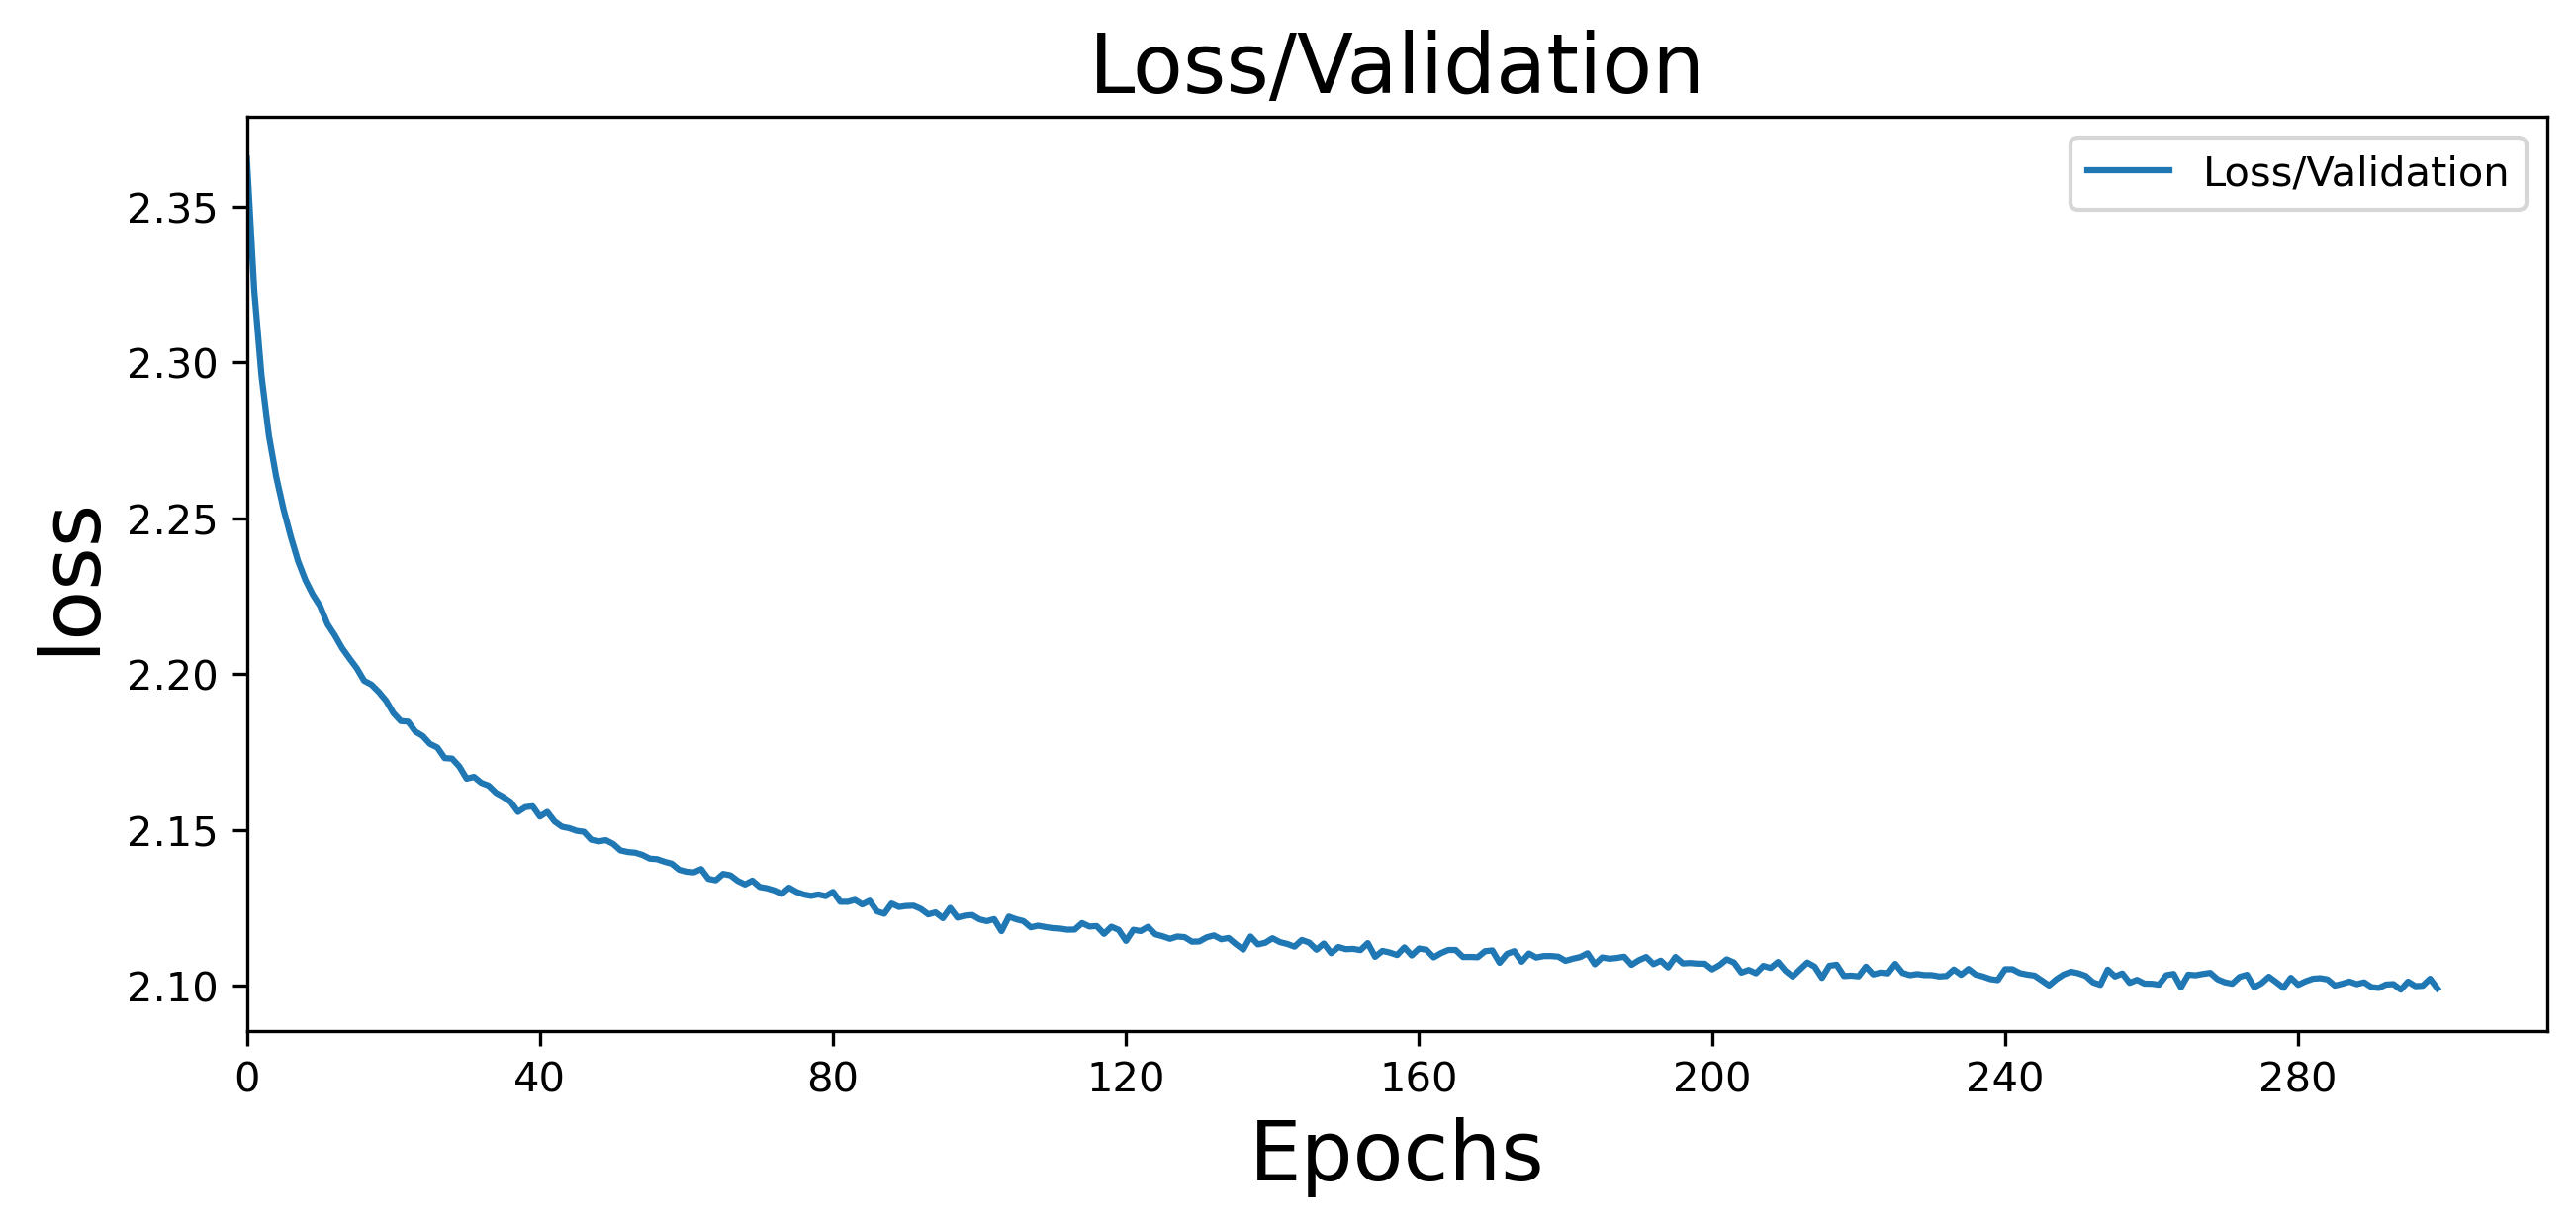

In [20]:
logger.plot_summary("Loss/Validation")

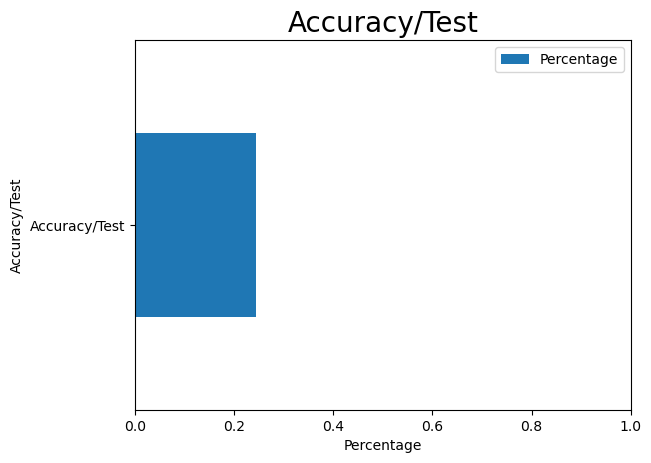

In [21]:
logger.plot_summary("Accuracy/Test")

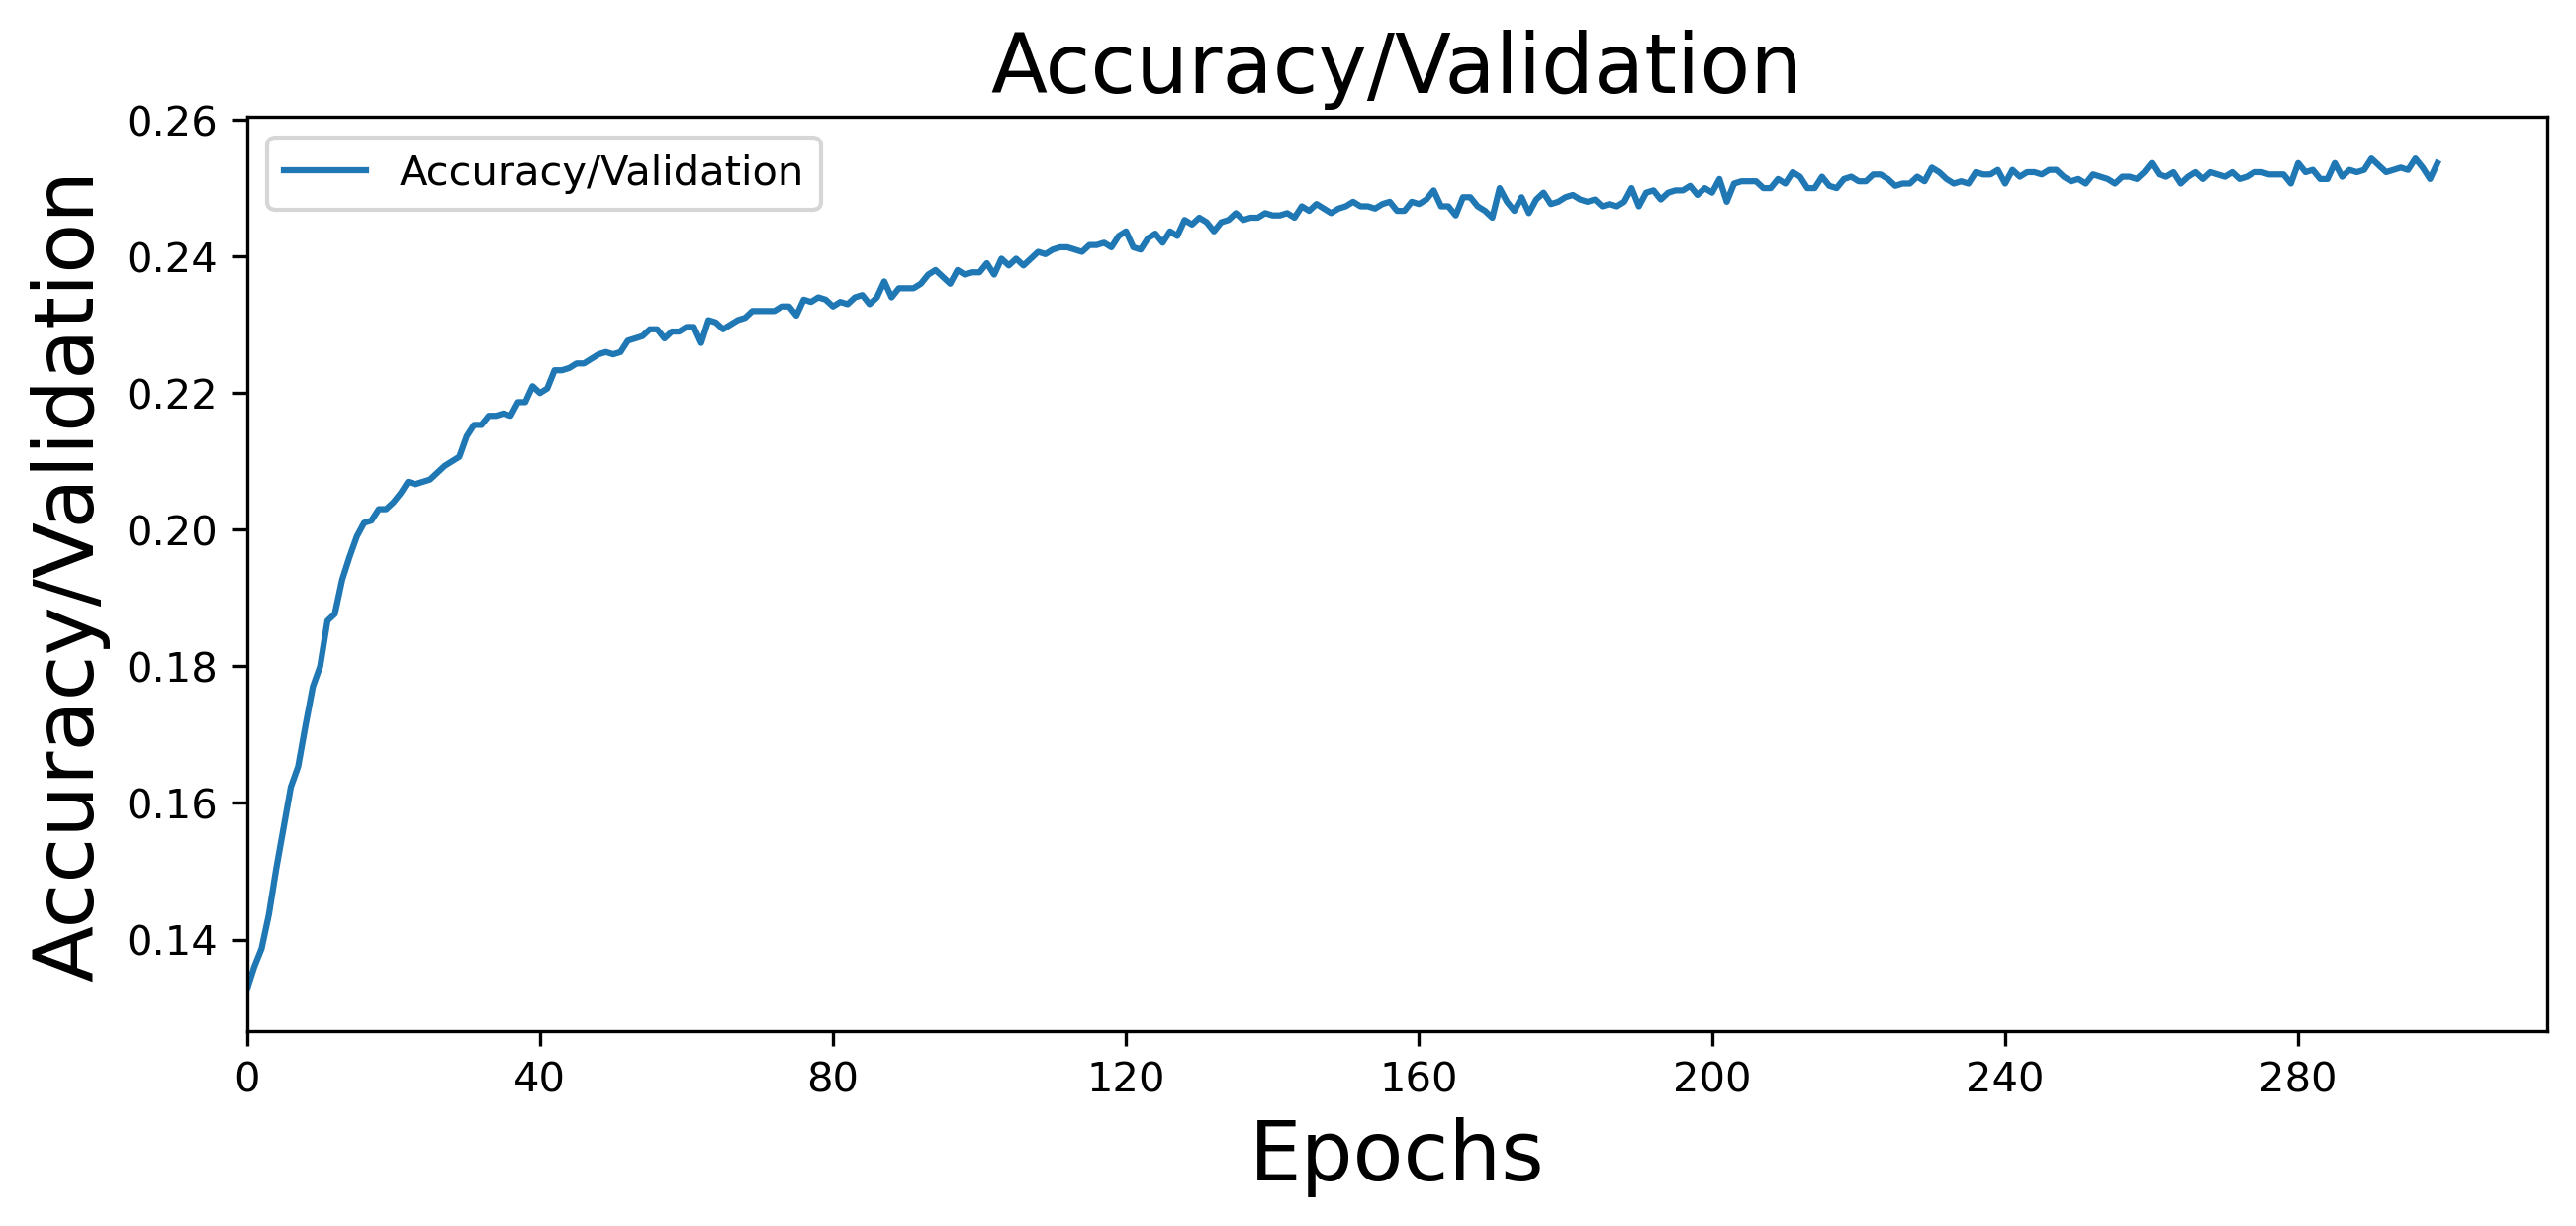

In [22]:
logger.plot_summary("Accuracy/Validation")

## Test

In [16]:
logger = TrainerLogger(logging_dir="./customlogdir")

model.to(device)
num_epochs = 3000
for epoch in range(num_epochs):
    model.train()
    for batch in tqdm(train_loader_preprocessed, desc=f"Epoch {epoch + 1}/ {num_epochs}"):
        optimizer.zero_grad()
        
        inputs, labels, titles = batch
        inputs = inputs.to(device)
        targets = torch.tensor(labels, dtype=torch.long)
        logits = model(**inputs).squeeze(0)
        
        loss = criterion(logits, targets.to(device))
        loss.backward()
        optimizer.step()
    
    model.eval()
    val_accuracy, avg_val_loss = val_loss_accuracy(model, val_loader_preprocessed)

    logger.log({
        "epoch": epoch,
        "Loss/Train": loss.item(),
        "Loss/Validation": avg_val_loss,
        "Accuracy/Validation": val_accuracy['accuracy']
    })

    if epoch % 500 == 0:
        print(f"Epoch {epoch + 1}/{num_epochs}, Loss: {loss.item()}, Validation Accuracy: {val_accuracy}")

model.eval()
test_accuracy = get_test_accuracy(model, train_loader_preprocessed)
logger.log({"Accuracy/Test": test_accuracy['accuracy']})

Epoch 1/ 3000:   0%|          | 0/1563 [00:00<?, ?it/s]

  0%|          | 0/94 [00:00<?, ?it/s]

Epoch 1/3000, Loss: 2.5308845043182373, Validation Accuracy: {'accuracy': 0.16666666666666666}


Epoch 2/ 3000:   0%|          | 0/1563 [00:00<?, ?it/s]

  0%|          | 0/94 [00:00<?, ?it/s]

Epoch 3/ 3000:   0%|          | 0/1563 [00:00<?, ?it/s]

  0%|          | 0/94 [00:00<?, ?it/s]

Epoch 4/ 3000:   0%|          | 0/1563 [00:00<?, ?it/s]

  0%|          | 0/94 [00:00<?, ?it/s]

Epoch 5/ 3000:   0%|          | 0/1563 [00:00<?, ?it/s]

  0%|          | 0/94 [00:00<?, ?it/s]

Epoch 6/ 3000:   0%|          | 0/1563 [00:00<?, ?it/s]

  0%|          | 0/94 [00:00<?, ?it/s]

Epoch 7/ 3000:   0%|          | 0/1563 [00:00<?, ?it/s]

  0%|          | 0/94 [00:00<?, ?it/s]

Epoch 8/ 3000:   0%|          | 0/1563 [00:00<?, ?it/s]

  0%|          | 0/94 [00:00<?, ?it/s]

Epoch 9/ 3000:   0%|          | 0/1563 [00:00<?, ?it/s]

  0%|          | 0/94 [00:00<?, ?it/s]

Epoch 10/ 3000:   0%|          | 0/1563 [00:00<?, ?it/s]

  0%|          | 0/94 [00:00<?, ?it/s]

Epoch 11/ 3000:   0%|          | 0/1563 [00:00<?, ?it/s]

  0%|          | 0/94 [00:00<?, ?it/s]

Epoch 12/ 3000:   0%|          | 0/1563 [00:00<?, ?it/s]

  0%|          | 0/94 [00:00<?, ?it/s]

Epoch 13/ 3000:   0%|          | 0/1563 [00:00<?, ?it/s]

  0%|          | 0/94 [00:00<?, ?it/s]

Epoch 14/ 3000:   0%|          | 0/1563 [00:00<?, ?it/s]

  0%|          | 0/94 [00:00<?, ?it/s]

Epoch 15/ 3000:   0%|          | 0/1563 [00:00<?, ?it/s]

  0%|          | 0/94 [00:00<?, ?it/s]

Epoch 16/ 3000:   0%|          | 0/1563 [00:00<?, ?it/s]

  0%|          | 0/94 [00:00<?, ?it/s]

Epoch 17/ 3000:   0%|          | 0/1563 [00:00<?, ?it/s]

  0%|          | 0/94 [00:00<?, ?it/s]

Epoch 18/ 3000:   0%|          | 0/1563 [00:00<?, ?it/s]

  0%|          | 0/94 [00:00<?, ?it/s]

Epoch 19/ 3000:   0%|          | 0/1563 [00:00<?, ?it/s]

  0%|          | 0/94 [00:00<?, ?it/s]

Epoch 20/ 3000:   0%|          | 0/1563 [00:00<?, ?it/s]

  0%|          | 0/94 [00:00<?, ?it/s]

Epoch 21/ 3000:   0%|          | 0/1563 [00:00<?, ?it/s]

  0%|          | 0/94 [00:00<?, ?it/s]

Epoch 22/ 3000:   0%|          | 0/1563 [00:00<?, ?it/s]

  0%|          | 0/94 [00:00<?, ?it/s]

Epoch 23/ 3000:   0%|          | 0/1563 [00:00<?, ?it/s]

  0%|          | 0/94 [00:00<?, ?it/s]

Epoch 24/ 3000:   0%|          | 0/1563 [00:00<?, ?it/s]

  0%|          | 0/94 [00:00<?, ?it/s]

Epoch 25/ 3000:   0%|          | 0/1563 [00:00<?, ?it/s]

  0%|          | 0/94 [00:00<?, ?it/s]

Epoch 26/ 3000:   0%|          | 0/1563 [00:00<?, ?it/s]

  0%|          | 0/94 [00:00<?, ?it/s]

Epoch 27/ 3000:   0%|          | 0/1563 [00:00<?, ?it/s]

  0%|          | 0/94 [00:00<?, ?it/s]

Epoch 28/ 3000:   0%|          | 0/1563 [00:00<?, ?it/s]

  0%|          | 0/94 [00:00<?, ?it/s]

Epoch 29/ 3000:   0%|          | 0/1563 [00:00<?, ?it/s]

  0%|          | 0/94 [00:00<?, ?it/s]

Epoch 30/ 3000:   0%|          | 0/1563 [00:00<?, ?it/s]

  0%|          | 0/94 [00:00<?, ?it/s]

Epoch 31/ 3000:   0%|          | 0/1563 [00:00<?, ?it/s]

  0%|          | 0/94 [00:00<?, ?it/s]

Epoch 32/ 3000:   0%|          | 0/1563 [00:00<?, ?it/s]

  0%|          | 0/94 [00:00<?, ?it/s]

Epoch 33/ 3000:   0%|          | 0/1563 [00:00<?, ?it/s]

  0%|          | 0/94 [00:00<?, ?it/s]

Epoch 34/ 3000:   0%|          | 0/1563 [00:00<?, ?it/s]

  0%|          | 0/94 [00:00<?, ?it/s]

Epoch 35/ 3000:   0%|          | 0/1563 [00:00<?, ?it/s]

  0%|          | 0/94 [00:00<?, ?it/s]

Epoch 36/ 3000:   0%|          | 0/1563 [00:00<?, ?it/s]

  0%|          | 0/94 [00:00<?, ?it/s]

Epoch 37/ 3000:   0%|          | 0/1563 [00:00<?, ?it/s]

  0%|          | 0/94 [00:00<?, ?it/s]

Epoch 38/ 3000:   0%|          | 0/1563 [00:00<?, ?it/s]

  0%|          | 0/94 [00:00<?, ?it/s]

Epoch 39/ 3000:   0%|          | 0/1563 [00:00<?, ?it/s]

  0%|          | 0/94 [00:00<?, ?it/s]

Epoch 40/ 3000:   0%|          | 0/1563 [00:00<?, ?it/s]

  0%|          | 0/94 [00:00<?, ?it/s]

Epoch 41/ 3000:   0%|          | 0/1563 [00:00<?, ?it/s]

  0%|          | 0/94 [00:00<?, ?it/s]

Epoch 42/ 3000:   0%|          | 0/1563 [00:00<?, ?it/s]

  0%|          | 0/94 [00:00<?, ?it/s]

Epoch 43/ 3000:   0%|          | 0/1563 [00:00<?, ?it/s]

  0%|          | 0/94 [00:00<?, ?it/s]

Epoch 44/ 3000:   0%|          | 0/1563 [00:00<?, ?it/s]

  0%|          | 0/94 [00:00<?, ?it/s]

Epoch 45/ 3000:   0%|          | 0/1563 [00:00<?, ?it/s]

  0%|          | 0/94 [00:00<?, ?it/s]

Epoch 46/ 3000:   0%|          | 0/1563 [00:00<?, ?it/s]

  0%|          | 0/94 [00:00<?, ?it/s]

Epoch 47/ 3000:   0%|          | 0/1563 [00:00<?, ?it/s]

  0%|          | 0/94 [00:00<?, ?it/s]

Epoch 48/ 3000:   0%|          | 0/1563 [00:00<?, ?it/s]

  0%|          | 0/94 [00:00<?, ?it/s]

Epoch 49/ 3000:   0%|          | 0/1563 [00:00<?, ?it/s]

  0%|          | 0/94 [00:00<?, ?it/s]

Epoch 50/ 3000:   0%|          | 0/1563 [00:00<?, ?it/s]

  0%|          | 0/94 [00:00<?, ?it/s]

Epoch 51/ 3000:   0%|          | 0/1563 [00:00<?, ?it/s]

  0%|          | 0/94 [00:00<?, ?it/s]

Epoch 52/ 3000:   0%|          | 0/1563 [00:00<?, ?it/s]

  0%|          | 0/94 [00:00<?, ?it/s]

Epoch 53/ 3000:   0%|          | 0/1563 [00:00<?, ?it/s]

  0%|          | 0/94 [00:00<?, ?it/s]

Epoch 54/ 3000:   0%|          | 0/1563 [00:00<?, ?it/s]

  0%|          | 0/94 [00:00<?, ?it/s]

Epoch 55/ 3000:   0%|          | 0/1563 [00:00<?, ?it/s]

  0%|          | 0/94 [00:00<?, ?it/s]

Epoch 56/ 3000:   0%|          | 0/1563 [00:00<?, ?it/s]

  0%|          | 0/94 [00:00<?, ?it/s]

Epoch 57/ 3000:   0%|          | 0/1563 [00:00<?, ?it/s]

  0%|          | 0/94 [00:00<?, ?it/s]

Epoch 58/ 3000:   0%|          | 0/1563 [00:00<?, ?it/s]

  0%|          | 0/94 [00:00<?, ?it/s]

Epoch 59/ 3000:   0%|          | 0/1563 [00:00<?, ?it/s]

  0%|          | 0/94 [00:00<?, ?it/s]

Epoch 60/ 3000:   0%|          | 0/1563 [00:00<?, ?it/s]

  0%|          | 0/94 [00:00<?, ?it/s]

Epoch 61/ 3000:   0%|          | 0/1563 [00:00<?, ?it/s]

  0%|          | 0/94 [00:00<?, ?it/s]

Epoch 62/ 3000:   0%|          | 0/1563 [00:00<?, ?it/s]

  0%|          | 0/94 [00:00<?, ?it/s]

Epoch 63/ 3000:   0%|          | 0/1563 [00:00<?, ?it/s]

  0%|          | 0/94 [00:00<?, ?it/s]

Epoch 64/ 3000:   0%|          | 0/1563 [00:00<?, ?it/s]

  0%|          | 0/94 [00:00<?, ?it/s]

Epoch 65/ 3000:   0%|          | 0/1563 [00:00<?, ?it/s]

  0%|          | 0/94 [00:00<?, ?it/s]

Epoch 66/ 3000:   0%|          | 0/1563 [00:00<?, ?it/s]

  0%|          | 0/94 [00:00<?, ?it/s]

Epoch 67/ 3000:   0%|          | 0/1563 [00:00<?, ?it/s]

  0%|          | 0/94 [00:00<?, ?it/s]

Epoch 68/ 3000:   0%|          | 0/1563 [00:00<?, ?it/s]

  0%|          | 0/94 [00:00<?, ?it/s]

Epoch 69/ 3000:   0%|          | 0/1563 [00:00<?, ?it/s]

  0%|          | 0/94 [00:00<?, ?it/s]

Epoch 70/ 3000:   0%|          | 0/1563 [00:00<?, ?it/s]

  0%|          | 0/94 [00:00<?, ?it/s]

Epoch 71/ 3000:   0%|          | 0/1563 [00:00<?, ?it/s]

  0%|          | 0/94 [00:00<?, ?it/s]

Epoch 72/ 3000:   0%|          | 0/1563 [00:00<?, ?it/s]

  0%|          | 0/94 [00:00<?, ?it/s]

Epoch 73/ 3000:   0%|          | 0/1563 [00:00<?, ?it/s]

  0%|          | 0/94 [00:00<?, ?it/s]

Epoch 74/ 3000:   0%|          | 0/1563 [00:00<?, ?it/s]

  0%|          | 0/94 [00:00<?, ?it/s]

Epoch 75/ 3000:   0%|          | 0/1563 [00:00<?, ?it/s]

  0%|          | 0/94 [00:00<?, ?it/s]

Epoch 76/ 3000:   0%|          | 0/1563 [00:00<?, ?it/s]

  0%|          | 0/94 [00:00<?, ?it/s]

Epoch 77/ 3000:   0%|          | 0/1563 [00:00<?, ?it/s]

  0%|          | 0/94 [00:00<?, ?it/s]

Epoch 78/ 3000:   0%|          | 0/1563 [00:00<?, ?it/s]

  0%|          | 0/94 [00:00<?, ?it/s]

Epoch 79/ 3000:   0%|          | 0/1563 [00:00<?, ?it/s]

  0%|          | 0/94 [00:00<?, ?it/s]

Epoch 80/ 3000:   0%|          | 0/1563 [00:00<?, ?it/s]

  0%|          | 0/94 [00:00<?, ?it/s]

Epoch 81/ 3000:   0%|          | 0/1563 [00:00<?, ?it/s]

  0%|          | 0/94 [00:00<?, ?it/s]

Epoch 82/ 3000:   0%|          | 0/1563 [00:00<?, ?it/s]

  0%|          | 0/94 [00:00<?, ?it/s]

Epoch 83/ 3000:   0%|          | 0/1563 [00:00<?, ?it/s]

  0%|          | 0/94 [00:00<?, ?it/s]

Epoch 84/ 3000:   0%|          | 0/1563 [00:00<?, ?it/s]

  0%|          | 0/94 [00:00<?, ?it/s]

Epoch 85/ 3000:   0%|          | 0/1563 [00:00<?, ?it/s]

  0%|          | 0/94 [00:00<?, ?it/s]

Epoch 86/ 3000:   0%|          | 0/1563 [00:00<?, ?it/s]

  0%|          | 0/94 [00:00<?, ?it/s]

Epoch 87/ 3000:   0%|          | 0/1563 [00:00<?, ?it/s]

  0%|          | 0/94 [00:00<?, ?it/s]

Epoch 88/ 3000:   0%|          | 0/1563 [00:00<?, ?it/s]

  0%|          | 0/94 [00:00<?, ?it/s]

Epoch 89/ 3000:   0%|          | 0/1563 [00:00<?, ?it/s]

  0%|          | 0/94 [00:00<?, ?it/s]

Epoch 90/ 3000:   0%|          | 0/1563 [00:00<?, ?it/s]

  0%|          | 0/94 [00:00<?, ?it/s]

Epoch 91/ 3000:   0%|          | 0/1563 [00:00<?, ?it/s]

  0%|          | 0/94 [00:00<?, ?it/s]

Epoch 92/ 3000:   0%|          | 0/1563 [00:00<?, ?it/s]

  0%|          | 0/94 [00:00<?, ?it/s]

Epoch 93/ 3000:   0%|          | 0/1563 [00:00<?, ?it/s]

  0%|          | 0/94 [00:00<?, ?it/s]

Epoch 94/ 3000:   0%|          | 0/1563 [00:00<?, ?it/s]

  0%|          | 0/94 [00:00<?, ?it/s]

Epoch 95/ 3000:   0%|          | 0/1563 [00:00<?, ?it/s]

  0%|          | 0/94 [00:00<?, ?it/s]

Epoch 96/ 3000:   0%|          | 0/1563 [00:00<?, ?it/s]

  0%|          | 0/94 [00:00<?, ?it/s]

Epoch 97/ 3000:   0%|          | 0/1563 [00:00<?, ?it/s]

  0%|          | 0/94 [00:00<?, ?it/s]

Epoch 98/ 3000:   0%|          | 0/1563 [00:00<?, ?it/s]

  0%|          | 0/94 [00:00<?, ?it/s]

Epoch 99/ 3000:   0%|          | 0/1563 [00:00<?, ?it/s]

  0%|          | 0/94 [00:00<?, ?it/s]

Epoch 100/ 3000:   0%|          | 0/1563 [00:00<?, ?it/s]

  0%|          | 0/94 [00:00<?, ?it/s]

Epoch 101/ 3000:   0%|          | 0/1563 [00:00<?, ?it/s]

  0%|          | 0/94 [00:00<?, ?it/s]

Epoch 102/ 3000:   0%|          | 0/1563 [00:00<?, ?it/s]

  0%|          | 0/94 [00:00<?, ?it/s]

Epoch 103/ 3000:   0%|          | 0/1563 [00:00<?, ?it/s]

  0%|          | 0/94 [00:00<?, ?it/s]

Epoch 104/ 3000:   0%|          | 0/1563 [00:00<?, ?it/s]

  0%|          | 0/94 [00:00<?, ?it/s]

Epoch 105/ 3000:   0%|          | 0/1563 [00:00<?, ?it/s]

  0%|          | 0/94 [00:00<?, ?it/s]

Epoch 106/ 3000:   0%|          | 0/1563 [00:00<?, ?it/s]

  0%|          | 0/94 [00:00<?, ?it/s]

Epoch 107/ 3000:   0%|          | 0/1563 [00:00<?, ?it/s]

  0%|          | 0/94 [00:00<?, ?it/s]

Epoch 108/ 3000:   0%|          | 0/1563 [00:00<?, ?it/s]

  0%|          | 0/94 [00:00<?, ?it/s]

Epoch 109/ 3000:   0%|          | 0/1563 [00:00<?, ?it/s]

  0%|          | 0/94 [00:00<?, ?it/s]

Epoch 110/ 3000:   0%|          | 0/1563 [00:00<?, ?it/s]

  0%|          | 0/94 [00:00<?, ?it/s]

Epoch 111/ 3000:   0%|          | 0/1563 [00:00<?, ?it/s]

  0%|          | 0/94 [00:00<?, ?it/s]

Epoch 112/ 3000:   0%|          | 0/1563 [00:00<?, ?it/s]

  0%|          | 0/94 [00:00<?, ?it/s]

Epoch 113/ 3000:   0%|          | 0/1563 [00:00<?, ?it/s]

  0%|          | 0/94 [00:00<?, ?it/s]

Epoch 114/ 3000:   0%|          | 0/1563 [00:00<?, ?it/s]

  0%|          | 0/94 [00:00<?, ?it/s]

Epoch 115/ 3000:   0%|          | 0/1563 [00:00<?, ?it/s]

  0%|          | 0/94 [00:00<?, ?it/s]

Epoch 116/ 3000:   0%|          | 0/1563 [00:00<?, ?it/s]

  0%|          | 0/94 [00:00<?, ?it/s]

Epoch 117/ 3000:   0%|          | 0/1563 [00:00<?, ?it/s]

  0%|          | 0/94 [00:00<?, ?it/s]

Epoch 118/ 3000:   0%|          | 0/1563 [00:00<?, ?it/s]

  0%|          | 0/94 [00:00<?, ?it/s]

Epoch 119/ 3000:   0%|          | 0/1563 [00:00<?, ?it/s]

  0%|          | 0/94 [00:00<?, ?it/s]

Epoch 120/ 3000:   0%|          | 0/1563 [00:00<?, ?it/s]

  0%|          | 0/94 [00:00<?, ?it/s]

Epoch 121/ 3000:   0%|          | 0/1563 [00:00<?, ?it/s]

  0%|          | 0/94 [00:00<?, ?it/s]

Epoch 122/ 3000:   0%|          | 0/1563 [00:00<?, ?it/s]

  0%|          | 0/94 [00:00<?, ?it/s]

Epoch 123/ 3000:   0%|          | 0/1563 [00:00<?, ?it/s]

  0%|          | 0/94 [00:00<?, ?it/s]

Epoch 124/ 3000:   0%|          | 0/1563 [00:00<?, ?it/s]

  0%|          | 0/94 [00:00<?, ?it/s]

Epoch 125/ 3000:   0%|          | 0/1563 [00:00<?, ?it/s]

  0%|          | 0/94 [00:00<?, ?it/s]

Epoch 126/ 3000:   0%|          | 0/1563 [00:00<?, ?it/s]

  0%|          | 0/94 [00:00<?, ?it/s]

Epoch 127/ 3000:   0%|          | 0/1563 [00:00<?, ?it/s]

  0%|          | 0/94 [00:00<?, ?it/s]

Epoch 128/ 3000:   0%|          | 0/1563 [00:00<?, ?it/s]

  0%|          | 0/94 [00:00<?, ?it/s]

Epoch 129/ 3000:   0%|          | 0/1563 [00:00<?, ?it/s]

  0%|          | 0/94 [00:00<?, ?it/s]

Epoch 130/ 3000:   0%|          | 0/1563 [00:00<?, ?it/s]

  0%|          | 0/94 [00:00<?, ?it/s]

Epoch 131/ 3000:   0%|          | 0/1563 [00:00<?, ?it/s]

  0%|          | 0/94 [00:00<?, ?it/s]

Epoch 132/ 3000:   0%|          | 0/1563 [00:00<?, ?it/s]

  0%|          | 0/94 [00:00<?, ?it/s]

Epoch 133/ 3000:   0%|          | 0/1563 [00:00<?, ?it/s]

  0%|          | 0/94 [00:00<?, ?it/s]

Epoch 134/ 3000:   0%|          | 0/1563 [00:00<?, ?it/s]

  0%|          | 0/94 [00:00<?, ?it/s]

Epoch 135/ 3000:   0%|          | 0/1563 [00:00<?, ?it/s]

  0%|          | 0/94 [00:00<?, ?it/s]

Epoch 136/ 3000:   0%|          | 0/1563 [00:00<?, ?it/s]

  0%|          | 0/94 [00:00<?, ?it/s]

Epoch 137/ 3000:   0%|          | 0/1563 [00:00<?, ?it/s]

  0%|          | 0/94 [00:00<?, ?it/s]

Epoch 138/ 3000:   0%|          | 0/1563 [00:00<?, ?it/s]

  0%|          | 0/94 [00:00<?, ?it/s]

Epoch 139/ 3000:   0%|          | 0/1563 [00:00<?, ?it/s]

  0%|          | 0/94 [00:00<?, ?it/s]

Epoch 140/ 3000:   0%|          | 0/1563 [00:00<?, ?it/s]

  0%|          | 0/94 [00:00<?, ?it/s]

Epoch 141/ 3000:   0%|          | 0/1563 [00:00<?, ?it/s]

  0%|          | 0/94 [00:00<?, ?it/s]

Epoch 142/ 3000:   0%|          | 0/1563 [00:00<?, ?it/s]

  0%|          | 0/94 [00:00<?, ?it/s]

Epoch 143/ 3000:   0%|          | 0/1563 [00:00<?, ?it/s]

  0%|          | 0/94 [00:00<?, ?it/s]

Epoch 144/ 3000:   0%|          | 0/1563 [00:00<?, ?it/s]

  0%|          | 0/94 [00:00<?, ?it/s]

Epoch 145/ 3000:   0%|          | 0/1563 [00:00<?, ?it/s]

  0%|          | 0/94 [00:00<?, ?it/s]

Epoch 146/ 3000:   0%|          | 0/1563 [00:00<?, ?it/s]

  0%|          | 0/94 [00:00<?, ?it/s]

Epoch 147/ 3000:   0%|          | 0/1563 [00:00<?, ?it/s]

  0%|          | 0/94 [00:00<?, ?it/s]

Epoch 148/ 3000:   0%|          | 0/1563 [00:00<?, ?it/s]

  0%|          | 0/94 [00:00<?, ?it/s]

Epoch 149/ 3000:   0%|          | 0/1563 [00:00<?, ?it/s]

  0%|          | 0/94 [00:00<?, ?it/s]

Epoch 150/ 3000:   0%|          | 0/1563 [00:00<?, ?it/s]

  0%|          | 0/94 [00:00<?, ?it/s]

Epoch 151/ 3000:   0%|          | 0/1563 [00:00<?, ?it/s]

  0%|          | 0/94 [00:00<?, ?it/s]

Epoch 152/ 3000:   0%|          | 0/1563 [00:00<?, ?it/s]

  0%|          | 0/94 [00:00<?, ?it/s]

Epoch 153/ 3000:   0%|          | 0/1563 [00:00<?, ?it/s]

  0%|          | 0/94 [00:00<?, ?it/s]

Epoch 154/ 3000:   0%|          | 0/1563 [00:00<?, ?it/s]

  0%|          | 0/94 [00:00<?, ?it/s]

Epoch 155/ 3000:   0%|          | 0/1563 [00:00<?, ?it/s]

  0%|          | 0/94 [00:00<?, ?it/s]

Epoch 156/ 3000:   0%|          | 0/1563 [00:00<?, ?it/s]

  0%|          | 0/94 [00:00<?, ?it/s]

Epoch 157/ 3000:   0%|          | 0/1563 [00:00<?, ?it/s]

  0%|          | 0/94 [00:00<?, ?it/s]

Epoch 158/ 3000:   0%|          | 0/1563 [00:00<?, ?it/s]

  0%|          | 0/94 [00:00<?, ?it/s]

Epoch 159/ 3000:   0%|          | 0/1563 [00:00<?, ?it/s]

  0%|          | 0/94 [00:00<?, ?it/s]

Epoch 160/ 3000:   0%|          | 0/1563 [00:00<?, ?it/s]

  0%|          | 0/94 [00:00<?, ?it/s]

Epoch 161/ 3000:   0%|          | 0/1563 [00:00<?, ?it/s]

  0%|          | 0/94 [00:00<?, ?it/s]

Epoch 162/ 3000:   0%|          | 0/1563 [00:00<?, ?it/s]

  0%|          | 0/94 [00:00<?, ?it/s]

Epoch 163/ 3000:   0%|          | 0/1563 [00:00<?, ?it/s]

  0%|          | 0/94 [00:00<?, ?it/s]

Epoch 164/ 3000:   0%|          | 0/1563 [00:00<?, ?it/s]

  0%|          | 0/94 [00:00<?, ?it/s]

Epoch 165/ 3000:   0%|          | 0/1563 [00:00<?, ?it/s]

  0%|          | 0/94 [00:00<?, ?it/s]

Epoch 166/ 3000:   0%|          | 0/1563 [00:00<?, ?it/s]

  0%|          | 0/94 [00:00<?, ?it/s]

Epoch 167/ 3000:   0%|          | 0/1563 [00:00<?, ?it/s]

  0%|          | 0/94 [00:00<?, ?it/s]

Epoch 168/ 3000:   0%|          | 0/1563 [00:00<?, ?it/s]

  0%|          | 0/94 [00:00<?, ?it/s]

Epoch 169/ 3000:   0%|          | 0/1563 [00:00<?, ?it/s]

  0%|          | 0/94 [00:00<?, ?it/s]

Epoch 170/ 3000:   0%|          | 0/1563 [00:00<?, ?it/s]

  0%|          | 0/94 [00:00<?, ?it/s]

Epoch 171/ 3000:   0%|          | 0/1563 [00:00<?, ?it/s]

  0%|          | 0/94 [00:00<?, ?it/s]

Epoch 172/ 3000:   0%|          | 0/1563 [00:00<?, ?it/s]

  0%|          | 0/94 [00:00<?, ?it/s]

Epoch 173/ 3000:   0%|          | 0/1563 [00:00<?, ?it/s]

  0%|          | 0/94 [00:00<?, ?it/s]

Epoch 174/ 3000:   0%|          | 0/1563 [00:00<?, ?it/s]

  0%|          | 0/94 [00:00<?, ?it/s]

Epoch 175/ 3000:   0%|          | 0/1563 [00:00<?, ?it/s]

  0%|          | 0/94 [00:00<?, ?it/s]

Epoch 176/ 3000:   0%|          | 0/1563 [00:00<?, ?it/s]

  0%|          | 0/94 [00:00<?, ?it/s]

Epoch 177/ 3000:   0%|          | 0/1563 [00:00<?, ?it/s]

  0%|          | 0/94 [00:00<?, ?it/s]

Epoch 178/ 3000:   0%|          | 0/1563 [00:00<?, ?it/s]

  0%|          | 0/94 [00:00<?, ?it/s]

Epoch 179/ 3000:   0%|          | 0/1563 [00:00<?, ?it/s]

  0%|          | 0/94 [00:00<?, ?it/s]

Epoch 180/ 3000:   0%|          | 0/1563 [00:00<?, ?it/s]

  0%|          | 0/94 [00:00<?, ?it/s]

Epoch 181/ 3000:   0%|          | 0/1563 [00:00<?, ?it/s]

  0%|          | 0/94 [00:00<?, ?it/s]

Epoch 182/ 3000:   0%|          | 0/1563 [00:00<?, ?it/s]

  0%|          | 0/94 [00:00<?, ?it/s]

Epoch 183/ 3000:   0%|          | 0/1563 [00:00<?, ?it/s]

  0%|          | 0/94 [00:00<?, ?it/s]

Epoch 184/ 3000:   0%|          | 0/1563 [00:00<?, ?it/s]

  0%|          | 0/94 [00:00<?, ?it/s]

Epoch 185/ 3000:   0%|          | 0/1563 [00:00<?, ?it/s]

  0%|          | 0/94 [00:00<?, ?it/s]

Epoch 186/ 3000:   0%|          | 0/1563 [00:00<?, ?it/s]

  0%|          | 0/94 [00:00<?, ?it/s]

Epoch 187/ 3000:   0%|          | 0/1563 [00:00<?, ?it/s]

  0%|          | 0/94 [00:00<?, ?it/s]

Epoch 188/ 3000:   0%|          | 0/1563 [00:00<?, ?it/s]

  0%|          | 0/94 [00:00<?, ?it/s]

Epoch 189/ 3000:   0%|          | 0/1563 [00:00<?, ?it/s]

  0%|          | 0/94 [00:00<?, ?it/s]

Epoch 190/ 3000:   0%|          | 0/1563 [00:00<?, ?it/s]

  0%|          | 0/94 [00:00<?, ?it/s]

Epoch 191/ 3000:   0%|          | 0/1563 [00:00<?, ?it/s]

  0%|          | 0/94 [00:00<?, ?it/s]

Epoch 192/ 3000:   0%|          | 0/1563 [00:00<?, ?it/s]

  0%|          | 0/94 [00:00<?, ?it/s]

Epoch 193/ 3000:   0%|          | 0/1563 [00:00<?, ?it/s]

  0%|          | 0/94 [00:00<?, ?it/s]

Epoch 194/ 3000:   0%|          | 0/1563 [00:00<?, ?it/s]

KeyboardInterrupt: 